In [1]:
# HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()

from scipy.stats.mstats import winsorize
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.pyplot as plt
from modules.la_mapping import lower_tier_sandwich, lower_tier_layer, gdf_chart
from modules import la

matplotlib_axes_logger.setLevel('ERROR')

data_year = 2019


# CO2 emissions cluster analysis - variable investigation

The goal of this analysis is to use [BEIS measures of the CO2 emissions](https://data.gov.uk/dataset/723c243d-2f1a-4d27-8b61-cdb93e5b10ff/uk-local-authority-and-regional-carbon-dioxide-emissions-national-statistics-2005-to-2019) under a local authorities control (the subset dataset) to:

1. Determine for each council which other councils are most similar. 
2. Group councils into clusters that explain broadly the problem of their emissions and why they are similar. 

This second attempt uses as dimensions the five grand totals for Industry, Commerical, Domestic, Public Sector, Transport.  

The first attempt used per head emissions to try and isolate the problem of 'big' or dense authorities. However, this caused some problems on the other end, where low density areas could end up with very high emissions. 

The specific things we want to avoid in this run is comparisons where some Scottish councils (Clackmannanshire and Moray) from being clustered with central London. The previous round also grouped counties into their own cluster, which once population is abstracted out *should* be avoidable. 

A different approach by Connected Places catapult used regional GDP to standardize. This if applied to industrial emissions should solve some of the problems and the thinking makes sense that an area is responsible for X GDP, and Y industrial emissions, we're looking for councils with a similar relationship between those two things. Although possibly this also the case for a seperate GDP/area/pop set of clusters.

Following the exploration in the emissions.v2-prep notebook, this notebook tries to cluster based on an approach that:

* Adjusts domestic to be per head
* Adjusts commerical and industrial to be per unit of GDP
* Adjusts the others by a winsorised per head (which just clips population counts for a few counts at the very top and bottom of the distribution)
* A weighted down version of population density is used as an extra factor to push dissimilar councils a little bit more apart.

For reference later, industry is split from commericals by a set of specific SIC codes, and 'public sector' is made of the following SIC codes:

* Public administration and defence; compulsory social security
* Education
* Human health activities
* Residential care activities

In [2]:
# get our basic emissions dataset up to date

df = pd.read_excel(Path("data", "2005-19_UK_local_and_regional_CO2_emissions.xlsx"),
                   sheet_name="Subset dataset", header=1)
df = df.loc[df["Year"] == data_year].loc[~df["Code"].isna()]

used_cols = ["Industry Total", "Commercial Total",
             "Domestic Total", "Public Sector Total", "Transport Total"]

df = df[["Code"] + used_cols]

# transform to modern councils
df = (df
      .la.code_from_gss("Code", drop=True)
      .la.to_current()
      .la.just_lower_tier()
      .la.get_council_info(["pop-2020"])
      .set_index("local-authority-code")
      )

gdp = pd.read_excel(Path(
    "data", "source", "regionalgrossdomesticproductlocalauthorities.xlsx"), sheet_name="Table 5", header=1)
gdp.columns = list(gdp.columns)[:-1] + ["2019"]
gdp = (gdp[["LA code", "2019"]]
       .loc[lambda df: ~df["LA code"].isna()]
       .la.code_from_gss("LA code", set_index=True,
                         drop=True)
       .rename(columns={"2019": "gdp"}))

df = df.join(gdp)
odf = df.copy()
df.head()


,Industry Total,Commercial Total,Domestic Total,Public Sector Total,Transport Total,pop-2020,gdp
local-authority-code,,,,,,,
ABC,440.90,40.71,384.13,9.55,438.66,217232.0,4730.0
ABD,310.28,97.45,482.37,21.37,626.50,260780.0,7961.0
ABE,151.96,155.54,341.95,97.05,326.71,229060.0,11225.0
ADU,18.72,15.36,80.96,4.30,93.63,64187.0,1401.0
AGB,108.17,44.95,161.38,15.53,182.79,85430.0,2234.0


# Create distances

Here we are adapting industry and commerical by local GDP, domestic by actual per head, and public sector and transport by a lightly winsorised per head. 

All of these decisions are fairly artibrary, but successfully avoid clustering Clackmannanshire with central London, avoid a seperate cluster for high level geographies, but generally preserve the broad pattern of the previous attempt. 

In [3]:

def winsor(series, p=0.05):
    array = winsorize(series, limits=(p, p))
    return pd.Series(array, index=series.index).sort_index()

# do winsor on lower tier, so not just clipping the combined authorities when they're present
odf["wpop"] = winsor(odf["pop-2020"], p=0.05)
higher_df = odf.la.to_multiple_higher(aggfunc="sum").set_index("local-authority-code")
df = pd.concat([odf, higher_df])
cols = ["Public Sector Total", "Transport Total"]
for c in cols:
    df[c] = (df[c]/df["wpop"])
    
df["Domestic Total"] = df["Domestic Total"]/df["pop-2020"]
df["Industry Total"] = df["Industry Total"]/df["gdp"]
df["Commercial Total"] = df["Commercial Total"]/df["gdp"]
df = df[used_cols]


In [4]:

# density is scaled down after it is normalized so it present as a pressure pushing apart dissimilar areas, but is far far less significant than the emissions.
def density_transform(series): return series * 0.25

d = df.copy()
d = d.la.add_info(["pop-2020", "area"])
d["density"] = winsor(d["pop-2020"]/d["area"], p=0.05)
d = d.drop(columns=["pop-2020", "area"])
d = (d
     .space.self_distance(normalize=True, transform={"density": density_transform})
     .space.match_distance()
     .space.local_rankings()
     .sort_values(["local-authority-code_A", "distance"]))

d.to_csv(Path("data", "outputs", "emissions",
          "distance_map.csv"), index=False)
d.head()


,local-authority-code_A,local-authority-code_B,distance,match,position
0,ABC,NMD,1.07,84.9,1.0
1,ABC,SEL,1.62,77.2,2.0
2,ABC,MEA,1.64,76.9,3.0
3,ABC,DRS,1.65,76.8,4.0
4,ABC,ANN,1.66,76.6,5.0


# Trying to cluster new approach

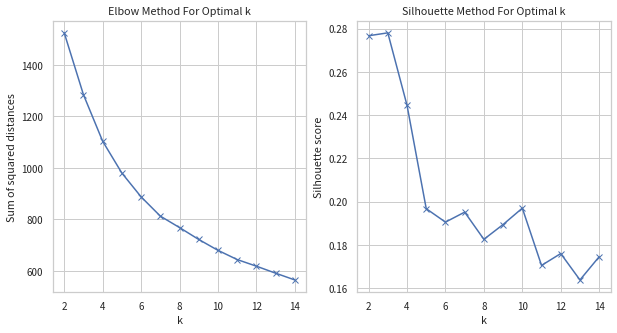

In [5]:

ruc = pd.read_csv(Path("data", "outputs", "ruc", "la_labels.csv")).set_index("local-authority-code").rename(columns={"label":"ruc"})


cdf = df
# Including London always gets put in its own cluster, remove
cdf = df.drop(["LND"])

cdf = cdf.la.add_info(["pop-2020", "area", "local-authority-type-name"])
cdf["density"] = winsor(cdf["pop-2020"]/cdf["area"], p=0.05)
cdf = cdf.drop(columns=["pop-2020", "area"])
cdf = cdf.join(ruc)


c = cdf.space.cluster(normalize=True, label_cols=["local-authority-type-name", "ruc"], transform={
                      "density": density_transform})  # lets make density a bit less important after normalization
c.find_k()


As usual, not a clear cluster. Chosing 5 because that's the number of nice colours we have (the primary means this data is interacted with is via distance anyway so the labelling is less imporant.)

In [6]:
c.set_k(5).stats()


,count,%,random members
labels,,,
1,102,25.0,"[HAR, BRX, BOL, BEN, SAW]"
2,16,3.9,"[PEM, SHN, STE, RIH, SFT]"
3,179,43.9,"[WAR, HPL, WOI, NTT, ORK]"
4,29,7.1,"[WDU, GLG, STV, PRE, SWK]"
5,82,20.1,"[FLN, BAB, TOR, PKN, EHA]"


In [7]:
c = c.set_k(5)
c.label_tool()


interactive(children=(Dropdown(description='cluster', options=(1, 2, 3, 4, 5), value=1), Dropdown(description=…

In [8]:
c.set_k(5).raincloud_tool(reverse=True)


interactive(children=(Dropdown(description='cluster_label', options=(1, 2, 3, 4, 5), value=1), Output()), _dom…

In [9]:
c.set_k(5).raincloud_tool()


interactive(children=(Dropdown(description='variable', options=('Industry Total', 'Commercial Total', 'Domesti…

# Labelling clusters

Reviewing the above tools, I needed to come up with labels for each cluster. Previouslt this was 3 urban and 2 rural categories. However this time round, it came up with less of a clear distinction (roughly 1 was definitely rural, and 5 is more suburban). Given this kind of catagorisation is now being handled by a seperate index, it seemed better to label based purely on emissions scores.

This presents a different problem, in that most of these are now so abstracted it's difficult to easily describe. 'High' is not necessary raw emissions. Some times a cluster's distinctive feature is 'below average' emissions but this is different from 'low' (from a zero perspective, all emissions are high).

As the goal is to encourage areas with similar problems to identify with each other, I've focused on the 'shared problem' end (higher emissions than average), and moved other features into the description. 




In [34]:
labels_d = {
            1: ("Urban mainstream", "Below average for most emissions scores."),
            2: ("Industry/commercial/public sector", "Above average industry/commercial and public sector."),
            3: ("Domestic", "Slightly above average in domestic emissions, below average public sector emissions."),
            4: ("Public sector", "Well above average public sector (government, education, health), below average in other areas."),
            5: ("Industry/domestic/transport", "Above average for industry/domestic/transport, below average public sector emissions.")
            }

labels_short_d = {
                  1: "Urban mainstream",
                  2: "Industry/commercial/public sector",
                  3: "Domestic",
                  4: "Public sector",
                  5: "Industry/domestic/transport"
                  }


c = c.add_labels(labels_d)


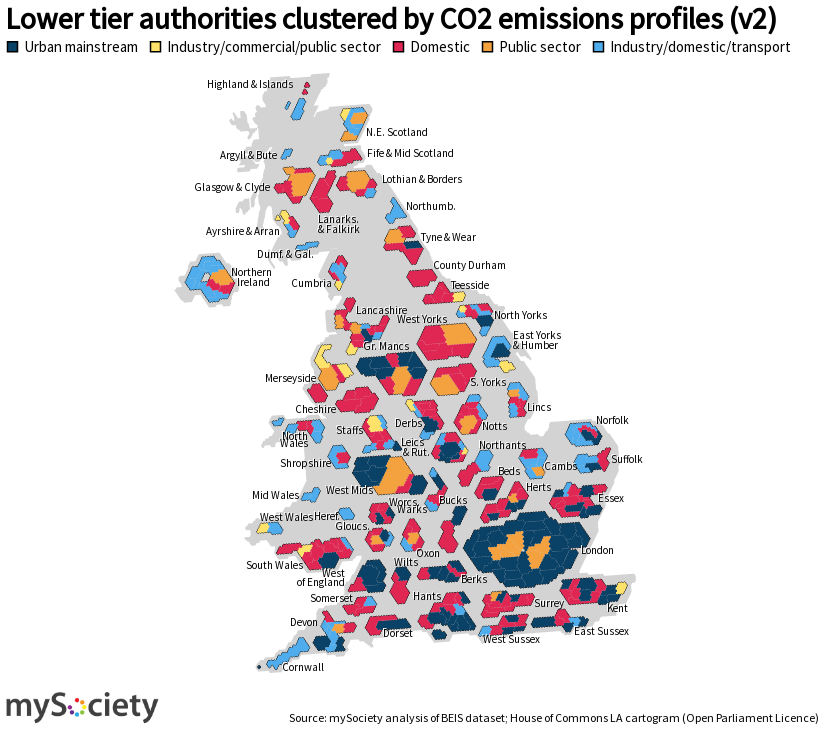

In [35]:
cdf["cluster_label"] = c.set_k(5).label_array(include_short=False)
cdf["cluster_label"]  = cdf["cluster_label"] #.common.update_from_map({"Industry/domestic/transport":"Ind./domestic/transport"})
la_layer = lower_tier_layer().join(cdf)

#labels = list(df["label"].unique())
#labels.sort(key=lambda x: x if x != "Other" else "Z", reverse=True)
labels = range(1, 6)

labels = [labels_short_d[x] for x in labels]

colors = [ "colour_dark_blue", "colour_yellow", "colour_berry",  "colour_orange", "colour_blue" ]

color_scale = altair_theme.color_scale(domain=labels, named_palette=colors)

# create chart layer
chart = gdf_chart(la_layer).mark_geoshape(
    stroke='black',
    strokeWidth=0
).encode(color=alt.Color("properties.cluster_label:O",
                         scale=color_scale,
                         legend=alt.Legend(title="", orient="top", titleFontSize=18, labelFontSize=15, titleLimit=400))
         ).properties(
    title="Lower tier authorities clustered by CO2 emissions profiles (v2)"
)

# put between layers
chart = lower_tier_sandwich(chart)
chart = chart.configure_legend(labelLimit=300)
chart = chart.properties(width=800, height=600)

caption = "Source: mySociety analysis of BEIS dataset; House of Commons LA cartogram (Open Parliament Licence)"
chart.display_options(logo=True, caption=caption)

chart.save(Path("data", "outputs", "emissions", "cluster_map_v2.png"), scale_factor=3, logo=True)
chart.display()

This is broadly looking good I think. Time to export the labels and descriptions in the common format. 

In [37]:
df = cdf.copy()
df["label"] = c.get_cluster_labels(include_short=False)
df["desc"] = c.get_cluster_descs()

df = df[["label", "desc"]]
df.loc["LND"] = ["City of London", "City of London does not have a comparable emissions profile"]
df = df.reset_index()

df[["local-authority-code", "label"]].to_csv(Path("data", "outputs", "emissions", "la_labels.csv"), index=False)

In [39]:
df.drop(columns=["local-authority-code"]).drop_duplicates().to_csv(Path("data", "outputs", "emissions", "label_desc.csv"), index=False)